# features generation function

In [2]:
from typing import Union
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from numba import njit
import matplotlib.pyplot as plt 

NANOSECOND = 1
MICROSECOND = 1000
MILLISECOND = 1000000
SECOND = 1000000000


def trades_balance(trades_df: pd.DataFrame, window: Union[str, int]) -> pd.Series:
    sells = trades_df["ask_amount"].rolling(window=window, min_periods=1).sum()
    buys = trades_df["bid_amount"].rolling(window=window, min_periods=1).sum()
    return (sells - buys) / (sells + buys + 1e-8)
    
def calc_spreads(lobs, depth,target_data):
    dfs = []
    for i in range(depth):
        bid = lobs[f"bids[{i}].price"]
        ask = lobs[f"asks[{i}].price"]
        dfs.append( (ask - bid).asof(target_data.index,) * target_data.side)
        
    res = pd.concat(dfs, axis=1)
    res.columns = [f"spread_{i}" for i in range(depth)]
    return res
    
def trades_balance(trades_df: pd.DataFrame, window: Union[str, int]) -> pd.Series:
    sells = trades_df["ask_amount"].rolling(window=window, min_periods=1).sum()
    buys = trades_df["bid_amount"].rolling(window=window, min_periods=1).sum()
    return (sells - buys) / (sells + buys + 1e-8)


def calc_imbalance(lobs: pd.DataFrame, lvl_count: int = 20) -> pd.Series:
    """
    Calculate order book imbalance across multiple levels for orderbook_solusdt
    
    Parameters:
    - lobs: DataFrame orderbook_solusdt(lobs) containing order book data (with asks[0-19] and bids[0-19])
    - lvl_count: Number of levels to include in imbalance calculation (default: 20 for all levels)
    
    Returns:
    - Series containing the imbalance calculation
    """
    if lvl_count > 20:
        lvl_count = 20  # Safeguard against requesting more levels than available
    bid_amount = sum(lobs[f"bids[{i}].amount"] for i in range(lvl_count))
    ask_amount = sum(lobs[f"asks[{i}].amount"] for i in range(lvl_count))
    return (bid_amount - ask_amount) / (bid_amount + ask_amount + 1e-8)


def vwap(books_df: pd.DataFrame, lvl_count: int) -> pd.Series:
    """Volume-weighted average price."""
    ask_weighted_price = sum(books_df[f"asks[{i}].price"] * books_df[f"asks[{i}].amount"] for i in range(lvl_count))
    ask_volume = sum(books_df[f"asks[{i}].amount"] for i in range(lvl_count))

    bid_weighted_price = sum(books_df[f"bids[{i}].price"] * books_df[f"bids[{i}].amount"] for i in range(lvl_count))
    bid_volume = sum(books_df[f"bids[{i}].amount"] for i in range(lvl_count))

    total_weighted_price = ask_weighted_price + bid_weighted_price
    total_volume = ask_volume + bid_volume

    vwap = total_weighted_price / total_volume

    return vwap / books_df["mid_price"]


def calculate_atr(data: pd.DataFrame, period: int = 14) -> pd.Series:
    """
    Calculates the Average True Range (ATR) indicator for market candlestick data.

    Parameters:
    - data: A pd.DataFrame with columns ['high', 'low', 'close']
    - period: The period for ATR calculation (default is 14)

    Returns:
    - pd.Series with the calculated ATR
    """
    high_low = data['high'] - data['low']
    high_close = np.abs(data['high'] - data['close'].shift())
    low_close = np.abs(data['low'] - data['close'].shift())

    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.rolling(window=period, min_periods=1).mean()

    return atr


    

def calculate_open_interest(data: pd.DataFrame) -> pd.Series:
    open_interest = data['bids[0].amount'] + data['asks[0].amount']
    return open_interest

def calculate_volume(trades_df: pd.DataFrame, window: Union[str, int]) -> pd.Series:
    volume = trades_df['ask_amount'].rolling(window=window, min_periods=1).sum() + trades_df['bid_amount'].rolling(window=window, min_periods=1).sum()
    return volume

def calculate_large_density(lobs: pd.DataFrame, volume_series: pd.Series) -> pd.Series:
    density = lobs['bids[0].amount'] + lobs['asks[0].amount']
    density, volume = density.align(volume_series, join='outer', fill_value=0)
    large_density = density[density > volume]
    return large_density

def calculate_rsi(data: pd.DataFrame, n: int = 14) -> pd.Series:
    return 100 - (100 / (1 + data.diff(1).mask(data.diff(1) < 0, 0).ewm(alpha=1 / n, adjust=False).mean() / data.diff(1).mask(data.diff(1) > 0, -0.0).abs().ewm(alpha=1 / n, adjust=False).mean()))

def calc_ema(df, n):
    return df.ewm(span = n, adjust = False).mean()


def realized_skew_v2(series):
    series = np.asarray(series)
    skew = np.sum(series**3)
    return np.sign(skew) * np.abs(skew)**(1/3)

def calc_skew_v2(series, window):
    index = series.index
    series = np.asarray(series)
    n = len(series)
    result = np.empty(n)
    result[:] = np.nan
    
    cumsum1 = np.cumsum(series)
    cumsum3 = np.cumsum(series**3)

    for i in range(n):
        start = max(0, i - window + 1)
        sum1 = cumsum1[i] - (cumsum1[start - 1] if start > 0 else 0)
        sum3 = cumsum3[i] - (cumsum3[start - 1] if start > 0 else 0)
        
        skew = np.sign(sum3) * np.abs(sum3)**(1/3)
        result[i] = skew
    result = pd.Series(result)
    result.index = index
    return result

def size_imbalance(lobs):
    bid_amount = 0
    ask_amount = 0
    for i in range(20):
        bid_amount += lobs["bids[" + str(i) + "].amount"]
        ask_amount += lobs["asks[" + str(i) + "].amount"]
    imbalance_size = bid_amount / ask_amount
    return imbalance_size

def trades_count(trades_df: pd.DataFrame, window: Union[str, int]) -> pd.Series:
    sells = trades_df["ask_amount"].rolling(window=window, min_periods=1).sum()
    buys = trades_df["bid_amount"].rolling(window=window, min_periods=1).sum()
    result = (sells + buys)
    return result
    
    

class Predictor:
    def __init__(self, full_model_path: Union[str, list[str]]):
        self.models = []
        for name in full_model_path:
            model = CatBoostClassifier()
            model.load_model(name, format="cbm")
            self.models.append(model)

    @staticmethod
    def model_name() -> Union[str, list[str]]:
        return ["20250108-012907_model_0_plzzzzz.cbm",
                "20250108-013028_model_1_plzzzzz.cbm",
                "20250108-013136_model_2_plzzzzz.cbm", 
                "20250108-013220_model_3_plzzzzz.cbm", 
                "20250108-013326_model_4_plzzzzz.cbm"]

    def predict(self, features: pd.DataFrame) -> pd.Series:
        """
        Method is called once every time new submission received
            Params:
                Your features returned from `calc_features` method

            Returns: pd.Series[float]
                Array of predicted returns (price_{n + 1} / price_{n} - 1).
                One value must be generated for every bbo dataframe timestamp
                so that len(Series) == len(bbos)
        """
        res = np.array([self.models[i].predict_proba(features)[:, 1] for i in range(len(self.models))]).mean(axis = 0)
        return res

    @staticmethod
    def calc_features(
        lobs: pd.DataFrame | None,
        agg_trades: pd.DataFrame | None,
        lobs_embedding: pd.DataFrame | None,
        target_data: pd.DataFrame | None,
    ) -> pd.DataFrame:
        
        target_data_preprocessed = target_data.copy()

        #1 - sol mid_price
        lobs["mid_price"] = (lobs["asks[0].price"] + lobs["bids[0].price"]) / 2
        sol_mid_price = lobs["mid_price"].asof(target_data_preprocessed.index)
        sol_mid_price.name = "sol_mid_price"

        #2 - btc mid price
        btcusdt_mid_price = lobs_embedding[lobs_embedding["instrument"] == "BTCUSDT"]["mid_price"]

        #3 - eth mid price
        ethusdt_mid_price = lobs_embedding[lobs_embedding["instrument"] == "ETHUSDT"]["mid_price"]

        #4 dev price
        main_btcusdt_dev = (lobs["mid_price"] / (btcusdt_mid_price.asof(lobs.index) + 1e-6)).asof(target_data_preprocessed.index) * target_data_preprocessed.side
        main_btcusdt_dev.name = "main_btcusdt_dev"

        main_ethusdt_dev = (lobs["mid_price"] / (ethusdt_mid_price.asof(lobs.index) + 1e-6)).asof(target_data_preprocessed.index) * target_data_preprocessed.side
        main_ethusdt_dev.name = "main_ethusdt_dev"

        main_solusdt_dev = (lobs["mid_price"] / (sol_mid_price.asof(lobs.index) + 1e-6)).asof(target_data_preprocessed.index) * target_data_preprocessed.side
        main_ethusdt_dev.name = "main_solusdt_dev"

        #5 distance to mid_price 
        distance_to_mid_price = (target_data_preprocessed.price / (lobs["mid_price"].asof(target_data_preprocessed.index) + 1e-6) - 1) * target_data_preprocessed.side
        distance_to_mid_price.name = "distance_to_mid_price"

        #6 imbalance 20/10/5
        imbalance_series_lvl_20 = calc_imbalance(lobs).asof(target_data.index) * target_data.side
        imbalance_series_lvl_20.name = "imbalance_lvl_20"

        imbalance_series_lvl_10 = calc_imbalance(lobs, lvl_count=10).asof(target_data.index) * target_data.side
        imbalance_series_lvl_10.name = "imbalance_lvl_10"

        imbalance_series_lvl_5 = calc_imbalance(lobs, lvl_count=5).asof(target_data.index) * target_data.side
        imbalance_series_lvl_5.name = "imbalance_lvl_5"

        #vwap
        depth = 5
        vwap_series = vwap(lobs, depth).asof(target_data_preprocessed.index) * target_data_preprocessed.side
        vwap_series.name = "vwap"
        

        #agg trades 
        solusdt_agg_trades = agg_trades[agg_trades["instrument"] == "SOLUSDT"]


        trades_ratio_series_1m = trades_balance(solusdt_agg_trades, 1 * 60 * SECOND).asof(target_data_preprocessed.index) * target_data_preprocessed.side
        trades_ratio_series_1m.name = "trades_ratio_1m"
        
        trades_ratio_series_5m = trades_balance(solusdt_agg_trades, 5 * 60 * SECOND).asof(target_data_preprocessed.index) * target_data_preprocessed.side
        trades_ratio_series_5m.name = "trades_ratio_5m"
        
        trades_ratio_series_15m = trades_balance(solusdt_agg_trades, 15 * 60 * SECOND).asof(target_data_preprocessed.index) * target_data_preprocessed.side
        trades_ratio_series_15m.name = "trades_ratio_15m"


        

        # Calculate ATR
        lobs["high"] = lobs[["asks[0].price", "bids[0].price"]].max(axis=1)
        lobs["low"] = lobs[["asks[0].price", "bids[0].price"]].min(axis=1)
        lobs["close"] = lobs["mid_price"]
        atr_series = calculate_atr(lobs, period=14).asof(target_data_preprocessed.index)
        atr_series.name = "atr"

        # Calculate Open Interest
        open_interest_series = calculate_open_interest(lobs).asof(target_data_preprocessed.index)
        open_interest_series.name = "open_interest"

        # Calculate Volume
        volume_series_1m = calculate_volume(solusdt_agg_trades, window=1 * 60 * SECOND).asof(target_data.index)
        volume_series_1m.name = "volume_1m"
        
        volume_series_5m = calculate_volume(solusdt_agg_trades, window=5 * 60 * SECOND).asof(target_data.index)
        volume_series_5m.name = "volume_5m"
        
        volume_series_15m = calculate_volume(solusdt_agg_trades, window=15 * 60 * SECOND).asof(target_data.index)
        volume_series_15m.name = "volume_15m"

        # Calculate Large Density
        large_density_series_1m = calculate_large_density(lobs, volume_series_1m).asof(target_data.index)
        large_density_series_1m.name = "large_density_1m"

        large_density_series_5m = calculate_large_density(lobs, volume_series_5m).asof(target_data.index)
        large_density_series_5m.name = "large_density_5m"

        large_density_series_15m = calculate_large_density(lobs, volume_series_15m).asof(target_data.index)
        large_density_series_15m.name = "large_density_15m"

        # Calculate ATR for volume
        #13
        lobs["high_volume"] = lobs[["asks[0].amount", "bids[0].amount"]].max(axis=1)
        lobs["low_volume"] = lobs[["asks[0].amount", "bids[0].amount"]].min(axis=1)
        lobs["close_volume"] = (lobs["asks[0].amount"] + lobs["bids[0].amount"]) / 2
        atr_volume_series = calculate_atr(lobs, period=14).asof(target_data.index)
        atr_volume_series.name = "atr_volume"


        # spread 
        spread_depth = 10
        spread_series = calc_spreads(lobs, spread_depth, target_data).asof(target_data.index)

        # rsi 
        rsi_series_sol = calculate_rsi(lobs["mid_price"], n=14).asof(target_data.index)
        rsi_series_sol.name = 'sol_rsi'

        rsi_series_btc = calculate_rsi(btcusdt_mid_price, n=14).asof(target_data.index)
        rsi_series_btc.name = 'btc_rsi'

        rsi_series_eth = calculate_rsi(ethusdt_mid_price, n=14).asof(target_data.index)
        rsi_series_eth.name = 'eth_rsi'

        #ema
        ema_series_sol_100 = calc_ema(sol_mid_price, n = 100).asof(target_data.index) # 200-тая емашка на 1 часовом тф
        ema_series_sol_100.name = 'sol_ma100'

        ema_series_sol_200 = calc_ema(sol_mid_price, n = 200).asof(target_data.index) # 200-тая емашка на 1 часовом тф
        ema_series_sol_200.name = 'sol_ma200'

        ema_series_sol_10 = calc_ema(sol_mid_price, 10).asof(target_data.index)
        ema_series_sol_10.name = 'sol_ema_10'

        ema_series_sol_20 = calc_ema(sol_mid_price, 20).asof(target_data.index)
        ema_series_sol_20.name = 'sol_ema_20'

        #skew
        skew_5s = calc_skew_v2(sol_mid_price, 5 * SECOND).asof(target_data.index)
        skew_5s.name = 'skew_5s'
        
        skew_10s = calc_skew_v2(sol_mid_price, 10 * SECOND).asof(target_data.index)
        skew_10s.name = 'skew_10s'
        
        skew_15s = calc_skew_v2(sol_mid_price, 15 * SECOND).asof(target_data.index)
        skew_15s.name = 'skew_15s'

        skew_30s = calc_skew_v2(sol_mid_price, 30 * SECOND).asof(target_data.index)
        skew_30s.name = 'skew_30s'
        
        skew_60s = calc_skew_v2(sol_mid_price, 60 * SECOND).asof(target_data.index)
        skew_60s.name = 'skew_60s'

        #new fet
        size_imbalance_series = (
            size_imbalance(lobs).asof(target_data.index) * target_data.side
        )
        size_imbalance_series.name = "size_imbalance"

        momentum_period = 5
        size_imbalance_momentum = size_imbalance_series.pct_change(periods=momentum_period)
        size_imbalance_momentum.name = "size_imbalance_momentum " + str(momentum_period)

        time_lag = 1e-06
        count_sol = trades_count(solusdt_agg_trades, int(time_lag * SECOND)).asof(target_data.index)
        count_sol.name = "count_sol" + str(time_lag)



        df = pd.concat(
            [                   
                target_data_preprocessed.side,
                vwap_series,
                
                trades_ratio_series_1m,
                trades_ratio_series_5m,
                trades_ratio_series_15m,
                
                distance_to_mid_price,
                
                main_ethusdt_dev,
                main_btcusdt_dev,
                
                imbalance_series_lvl_20,
                imbalance_series_lvl_10,
                imbalance_series_lvl_5,
                
                sol_mid_price,
                atr_series,
                open_interest_series,
                
                volume_series_1m,
                volume_series_5m,
                volume_series_15m,
                
                large_density_series_1m,
                large_density_series_5m,
                large_density_series_15m,
                
                atr_volume_series,
                
                rsi_series_sol,
                rsi_series_btc,
                rsi_series_eth,
                
                ema_series_sol_100,
                ema_series_sol_200,
                ema_series_sol_20,
                ema_series_sol_10,

                skew_5s,
                skew_10s,
                skew_15s,
                skew_30s,
                skew_60s,
                
                size_imbalance_momentum,
                count_sol,   
            ],
            axis=1,
        )

        windows = [5, 10,15]

        result = pd.concat({f"window_{window}": df.pct_change(periods=window) for window in windows},axis=1)

        df = pd.concat([df,result], axis = 1)
        return df


# Data operating

In [3]:
agg_trades = pd.read_parquet("train/agg_trades.parquet")
lobs_embedding = pd.read_parquet("train/orderbook_embedding.parquet")
lobs = pd.read_parquet("train/orderbook_solusdt.parquet")
target_data = pd.read_parquet("train/target_data_solusdt.parquet")
target = pd.read_parquet("train/target_solusdt.parquet")

In [29]:
display(agg_trades.head(5))
display(lobs_embedding.head(5))
display(lobs.head(5))
display(target_data.head(5))
target.head(5)

,bid_max_price,ask_max_price,bid_min_price,ask_min_price,bid_mean_price,ask_mean_price,bid_count,ask_count,bid_amount,ask_amount,instrument
timestamp_ns,,,,,,,,,,,
1726617603500000000,131.468002,131.466995,131.468002,131.466995,131.468002,131.466995,2.0,1.0,2.000,7.000,SOLUSDT
1726617603500000000,60281.101562,60281.000000,60281.101562,60281.000000,60281.105469,60281.000000,24.0,11.0,2.227,0.484,BTCUSDT
1726617603500000000,2340.600098,2340.590088,2340.600098,2340.590088,2340.600098,2340.590088,5.0,5.0,2.021,0.987,ETHUSDT
1726617603750000000,131.468002,131.466995,131.460007,131.455994,131.462601,131.462799,5.0,15.0,106.000,164.000,SOLUSDT
1726617603750000000,60285.398438,60285.300781,60281.101562,60281.000000,60282.195312,60281.453125,72.0,19.0,5.202,5.604,BTCUSDT


,mid_price,vwap_1_lvl,vwap_3_lvl,vwap_5_lvl,vwap_10_lvl,instrument
timestamp_ns,,,,,,
1726617601297832000,60281.050781,60281.039062,60281.035156,60281.019531,60281.132812,BTCUSDT
1726617601619148000,2340.595215,2340.592529,2340.596680,2340.614502,2340.603271,ETHUSDT
1726617601937205000,60281.050781,60281.031250,60281.031250,60281.015625,60281.140625,BTCUSDT
1726617603501883000,2340.595215,2340.592529,2340.591064,2340.591064,2340.586914,ETHUSDT
1726617603503510000,60281.050781,60281.023438,60281.015625,60280.992188,60281.015625,BTCUSDT


,asks[0].price,asks[0].amount,bids[0].price,bids[0].amount,asks[1].price,asks[1].amount,bids[1].price,bids[1].amount,asks[2].price,asks[2].amount,...,asks[19].amount,bids[19].price,bids[19].amount,mid_price,high,low,close,high_volume,low_volume,close_volume
timestamp_ns,,,,,,,,,,,,,,,,,,,,,
1726617601032619000,131.468002,233.0,131.466995,157.0,131.470993,1.0,131.466003,2.0,131.472000,1.0,...,114.0,131.440002,76.0,131.467499,131.468002,131.466995,131.467499,233.0,157.0,195.0
1726617601618093000,131.468002,233.0,131.466995,157.0,131.470993,1.0,131.466003,2.0,131.472000,1.0,...,114.0,131.440002,76.0,131.467499,131.468002,131.466995,131.467499,233.0,157.0,195.0
1726617603503948000,131.468002,159.0,131.466995,151.0,131.470993,1.0,131.466003,2.0,131.472000,1.0,...,114.0,131.438004,1.0,131.467499,131.468002,131.466995,131.467499,159.0,151.0,155.0
1726617603555395000,131.460007,58.0,131.459000,59.0,131.464996,66.0,131.457993,228.0,131.466995,109.0,...,201.0,131.434998,98.0,131.459503,131.460007,131.459000,131.459503,59.0,58.0,58.5
1726617603605917000,131.460007,115.0,131.459000,27.0,131.464005,19.0,131.457993,1.0,131.464996,135.0,...,4.0,131.432999,21.0,131.459503,131.460007,131.459000,131.459503,115.0,27.0,71.0


,side,price,amount
timestamp_ns,,,
1726617603492082000,1,131.466995,7.0
1726617603512695000,1,131.466995,1.0
1726617603512698000,1,131.466003,2.0
1726617603543949000,-1,131.460007,8.0
1726617603710144000,1,131.459000,1.0


,weight,target
timestamp_ns,,
1726617603492082000,0.397396,0
1726617603512695000,0.150202,0
1726617603512698000,0.207696,0
1726617603543949000,0.433219,1
1726617603710144000,0.120686,0


In [4]:
X = Predictor.calc_features(lobs, agg_trades, lobs_embedding, target_data)

In [5]:
X['sol_mid_price_next'] = X['sol_mid_price'].shift(-1).fillna(0)
y = np.where(X['sol_mid_price_next']>X['sol_mid_price'],1,-1)
del X['sol_mid_price_next']

# Model traning

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.33, shuffle = False)

In [6]:
from sklearn.metrics import log_loss
import gc
from catboost import CatBoostClassifier, Pool 
import lightgbm as lgb

cat_features = ['side']
params_research = {
    "use_best_model": True,
    "eval_metric": "Logloss",
    "iterations": 6000,
    "loss_function": "Logloss",
    "l2_leaf_reg": 50,
    "task_type": "CPU",
    "depth": 10,
    "early_stopping_rounds": 50,
    "learning_rate": 0.05,
}

models = []
model = CatBoostClassifier(**params_research)
model.fit(X_train, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test, y_test), 
        verbose=100)

    
        

0:	learn: 0.6163236	test: 0.6158701	best: 0.6158701 (0)	total: 1.86s	remaining: 3h 6m 6s
100:	learn: 0.2006765	test: 0.2009068	best: 0.2009068 (100)	total: 2m 13s	remaining: 2h 9m 38s
200:	learn: 0.1976065	test: 0.1992369	best: 0.1992369 (200)	total: 4m 25s	remaining: 2h 7m 52s
300:	learn: 0.1960058	test: 0.1984959	best: 0.1984959 (300)	total: 6m 45s	remaining: 2h 7m 57s
400:	learn: 0.1948068	test: 0.1981172	best: 0.1981172 (400)	total: 9m 19s	remaining: 2h 10m 7s
500:	learn: 0.1938044	test: 0.1978488	best: 0.1978488 (500)	total: 11m 43s	remaining: 2h 8m 37s
600:	learn: 0.1930264	test: 0.1977066	best: 0.1977066 (600)	total: 13m 56s	remaining: 2h 5m 10s
700:	learn: 0.1922506	test: 0.1975800	best: 0.1975781 (698)	total: 16m 12s	remaining: 2h 2m 34s
800:	learn: 0.1915367	test: 0.1975595	best: 0.1975269 (793)	total: 18m 30s	remaining: 2h 6s
900:	learn: 0.1908569	test: 0.1974815	best: 0.1974815 (900)	total: 20m 44s	remaining: 1h 57m 23s
Stopped by overfitting detector  (50 iterations wait)


In [7]:
model.save_model('strat_model.cbm')

# MODEL TESTING

In [7]:
model = CatBoostClassifier()
model.load_model('strat_model.cbm', format="cbm")

In [8]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [30]:
def func_plot(df, y_train, y_test, count_plot):
    #PNL plotting
    X = df.copy()

    X['pnl_cumsum'] = X['pnl'].cumsum()
    X['pnl_cumsum_max'] = X['pnl_cumsum'].cummax()
    X['pnl_dd'] = X['pnl_cumsum_max'] - X['pnl_cumsum']
    plt.figure(figsize=(20,7))
    plt.plot(X['pnl_cumsum'][-count_plot:],color='black')
    plt.plot(X['pnl_cumsum_max'][-count_plot:],color='red')
    if count_plot > len(y_test): 
        plt.axvline(x = X.index[-len(y_test)], color='black')
    plt.grid()
    plt.show()


def func_model_performance(df,X_test, risk_free):
    #metrics calculating
    df['pnl_cumsum'] = df['pnl'].cumsum()
    df['pnl_cumsum_max'] = df['pnl_cumsum'].cummax()
    df['pnl_dd'] = df['pnl_cumsum_max'] - df['pnl_cumsum']

    full = df
    train = df[(df.index<X_test.index[0])].reindex()
    test = df[(df.index>=X_test.index[0])].reindex()

    pnl_full  = round(full['pnl'].sum() ,6)
    pnl_train = round(train['pnl'].sum(),6)
    pnl_test  = round(test['pnl'].sum() ,6)
    
    delta = pd.to_datetime(full.index.max()) - pd.to_datetime(full.index.min())
    annual_yield_full  = round(pnl_full/delta.days*365*100 ,2)
    delta = pd.to_datetime(train.index.max()) - pd.to_datetime(train.index.min())
    annual_yield_train = round(pnl_train/delta.days*365*100,2)
    delta = pd.to_datetime(test.index.max()) - pd.to_datetime(test.index.min())
    annual_yield_test  = round(pnl_test/delta.days*365*100 ,2)

    mdd_full = round(full['pnl_dd'].max()  ,6)
    mdd_train = round(train['pnl_dd'].max(),6)
    mdd_test = round(test['pnl_dd'].max()  ,6)
    
    sharpe_full  = round( ((np.mean(full['pnl'])  * 60 * 24 * 365) - risk_free) / (np.std(full['pnl'])  * np.sqrt(60 * 24 * 365)) ,6)
    sharpe_train = round( ((np.mean(train['pnl']) * 60 * 24 * 365) - risk_free) / (np.std(train['pnl']) * np.sqrt(60 * 24 * 365)) ,6)
    sharpe_test  = round( ((np.mean(test['pnl'])  * 60 * 24 * 365) - risk_free) / (np.std(test['pnl'])  * np.sqrt(60 * 24 * 365)) ,6)

    print('           full       train      test')
    print('PNL      : {0: <10}'.format(pnl_full),'{0: <10}'.format(pnl_train),'{0: <10}'.format(pnl_test))
    print('MDD      : {0: <10}'.format(mdd_full),'{0: <10}'.format(mdd_train),'{0: <10}'.format(mdd_test))
    print('Sharpe   : {0: <10}'.format(sharpe_full),'{0: <10}'.format(sharpe_train),'{0: <10}'.format(sharpe_test))
    print('Yield    : {0: <6}%   '.format(annual_yield_full),'{0: <6}%   '.format(annual_yield_train),'{0: <6}%  '.format(annual_yield_test))
    
    target = sharpe_train
    return target

# stratagy results

In [16]:
df = X.copy()
df['sol_mid_price_next'] = df['sol_mid_price'].shift(-1).fillna(0)
df['position'] = list(y_pred_train) + list(y_pred_test)
df['return'] = (df['sol_mid_price_next'] - df['sol_mid_price']) / df['sol_mid_price']
df['pnl'] = df['position'] * df['return']
df = df[:-1]



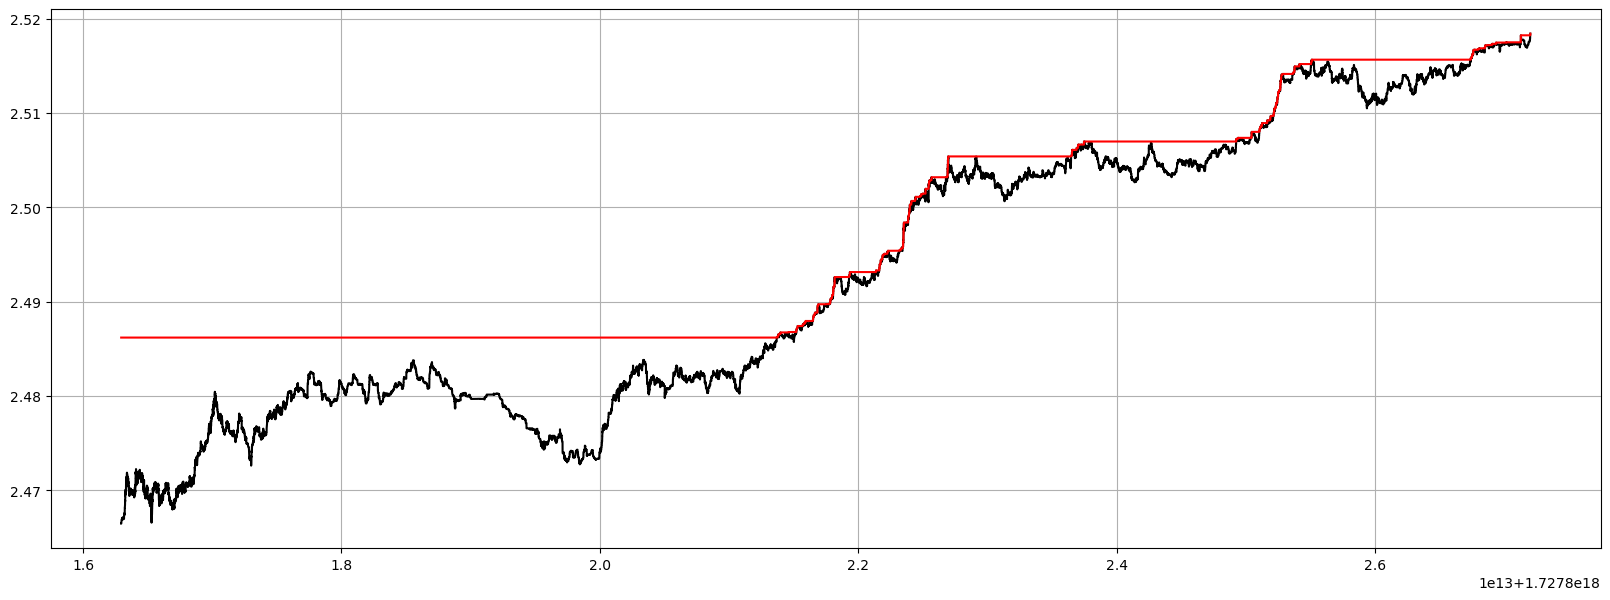

           full       train      test
PNL      : 2.5183639526367188 2.051487922668457 0.4668790102005005
MDD      : 0.036106   0.035542   0.036106  
Sharpe   : 6.082848   7.06555    3.800617  
Yield    : 7070.79%    8319.92%    4260.27%  


7.06555

In [28]:
func_plot(df, y_pred_train, y_pred_test, 100)
func_model_performance(df,X_test, 0)